In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gefry2
import cPickle as pickle

import shapely as sh
from shapely import geometry as g
from shapely.ops import cascaded_union

In [3]:
with open('./revised_geo.pkl') as f:
    geo = pickle.load(f)

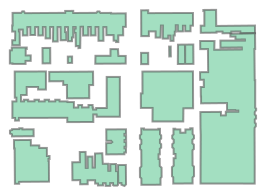

In [4]:
cascaded_union(geo)

In [5]:
xmin, ymin, xmax, ymax = cascaded_union(geo).bounds

In [6]:
cascaded_union(geo).bounds

(0.0, 0.0, 246.615, 176.333)

In [7]:
empty_dom = g.box(xmin, ymin, xmax, ymax).difference(cascaded_union(geo))

Perform rejection sampling to pick detector locations

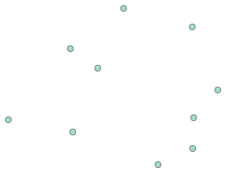

In [13]:
ND = 10
r_d = empty((ND, 2))
n = 0

while n < ND:
    xi, yi = random.uniform(low=[xmin, ymin], high=[xmax, ymax])
    r = g.Point((xi, yi))
    
    if empty_dom.contains(r):
        r_d[n] = [xi, yi]
        n += 1
    
cascaded_union(map(g.Point, r_d))

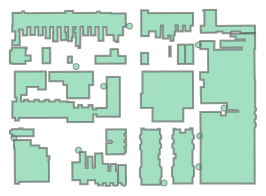

In [15]:
cascaded_union(geo + map(g.Point, r_d))

In [16]:
I_CS = 3.214e12 # 1g of cs-137

S = gefry2.Source((158, 98), I_CS / 1e3) # 10th of a gram of cs-137

In [17]:
dA = 0.005806 # m^2
D = [gefry2.Detector(i, 5.0, 0.62, dA) for i in r_d]

In [18]:
# Generate Xs'
# Want it s.t. 1mfp is about 20 m
sigma_0 = 1. / 20

sigma = random.uniform(low=(.8 * sigma_0), high=(1.2 * sigma_0), size=len(geo)) # 1 / m

In [19]:
dom = gefry2.Domain(geo, sigma)

In [20]:
P = gefry2.Problem(dom, D, S, 300)

In [21]:
P.nominal

array([359, 469, 301, 605, 476, 335, 386, 646, 610, 511])

In [22]:
NE = 10
data = array([P(S) for _ in xrange(NE)])
unc = sqrt(data)

savetxt('obs.dat', hstack((data, unc)), fmt='%.3f')

In [23]:
with open('problem.pkl', 'w') as f:
    pickle.dump([P, data, unc], f)

In [24]:
S_T = gefry2.Source((103, 160), 9.56e10)

In [25]:
((data - P(S_T))**2).sum(axis=1)

array([29708992, 29483046, 29937446, 29595243, 29517524, 29999683,
       29612231, 29926053, 29874748, 30193952])

# Fine mesh vis

In [30]:
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [31]:
from mpl_toolkits.mplot3d import Axes3D

In [32]:
nG = 30

XX = linspace(r_d[:, 0].min(), r_d[:, 0].max(), 30)
YY = linspace(r_d[:, 1].min(), r_d[:, 1].max(), 30)
dR = 25 # meters

xg, yg = meshgrid(XX, YY)
G = vstack((xg.ravel(), yg.ravel())).T
G = G[linalg.norm(G - S.loc, axis=1) > dR]

In [33]:
scatter(*G.T)

In [36]:
D2 = [gefry2.Detector(i, 5.0, 0.62, dA) for i in G]
P2 = gefry2.Problem(dom, D2, S, 300)

In [40]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(G[:, 0], G[:, 1], P2.nominal, alpha=1)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("cps")

In [208]:
S.loc

array([158,  98])